In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

https://youtu.be/IDIv92Z6Qvc

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.io
import plotting


In [15]:
from lib.pinn import PINN
from lib.network import Network
from lib.optimizer import L_BFGS_B

In [16]:
num_train_samples = 10000
num_test_samples = 1000
nu = 0.01 / np.pi

network = Network.build()
network.summary()
pinn = PINN(network, nu).build()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,201 (4.69 KB)

 Trainable params: 1,201 (4.69 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# create training input
tx_eqn = np.random.rand(num_train_samples, 2)          # t_eqn =  0 ~ +1
tx_eqn[..., 1] = 2 * tx_eqn[..., 1] - 1                # x_eqn = -1 ~ +1
tx_ini = 2 * np.random.rand(num_train_samples, 2) - 1  # x_ini = -1 ~ +1
tx_ini[..., 0] = 0                                     # t_ini =  0
tx_bnd = np.random.rand(num_train_samples, 2)          # t_bnd =  0 ~ +1
tx_bnd[..., 1] = 2 * np.round(tx_bnd[..., 1]) - 1      # x_bnd = -1 or +1
# create training output
u_eqn = np.zeros((num_train_samples, 1))               # u_eqn = 0
u_ini = np.sin(-np.pi * tx_ini[..., 1, np.newaxis])    # u_ini = -sin(pi*x_ini)
u_bnd = np.zeros((num_train_samples, 1))               # u_bnd = 0

# train the model using L-BFGS-B algorithm
x_train = [tx_eqn, tx_ini, tx_bnd]
y_train = [ u_eqn,  u_ini,  u_bnd]
lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
lbfgs.fit()

# predict u(t,x) distribution
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u = network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)



Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 269s 54ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


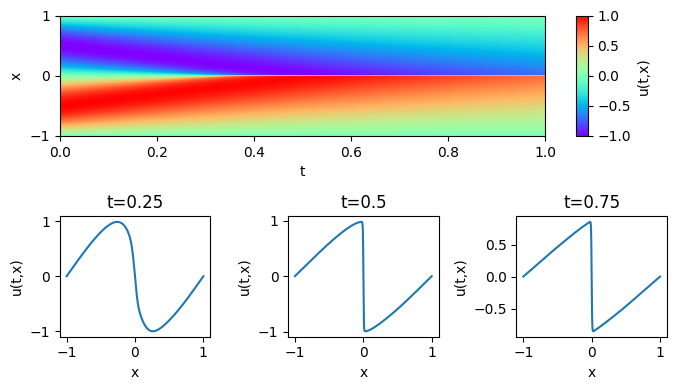

In [18]:
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 3)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u, cmap='rainbow')
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0.25, 0.5, 0.75]
for i, t_cs in enumerate(t_cross_sections):
    plt.subplot(gs[1, i])
    tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    plt.plot(x_flat, u)
    plt.title('t={}'.format(t_cs))
    plt.xlabel('x')
    plt.ylabel('u(t,x)')
plt.tight_layout()
plt.show()


In [51]:
data = scipy.io.loadmat('Data/burgers_shock.mat')
x = data['x'].flatten()[:,None]
t = data['t'].flatten()[:,None]
Exact = np.real(data['usol']).T
data


{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[-1.        ],
        [-0.99215686],
        [-0.98431373],
        [-0.97647059],
        [-0.96862745],
        [-0.96078431],
        [-0.95294118],
        [-0.94509804],
        [-0.9372549 ],
        [-0.92941176],
        [-0.92156863],
        [-0.91372549],
        [-0.90588235],
        [-0.89803922],
        [-0.89019608],
        [-0.88235294],
        [-0.8745098 ],
        [-0.86666667],
        [-0.85882353],
        [-0.85098039],
        [-0.84313725],
        [-0.83529412],
        [-0.82745098],
        [-0.81960784],
        [-0.81176471],
        [-0.80392157],
        [-0.79607843],
        [-0.78823529],
        [-0.78039216],
        [-0.77254902],
        [-0.76470588],
        [-0.75686275],
        [-0.74901961],
        [-0.74117647],
        [-0.73333333],
        [-0.7254902 ],
        [-0.71764706],
        